In [0]:
csv_path1 ="/Volumes/workspace/default/product/task.csv"  
csv_path2= "/Volumes/workspace/default/product/attendance.csv"
csv_path3= "/Volumes/workspace/default/product/employee.csv"
task_df = spark.read.option("header", "true").option("inferSchema", "true").csv(csv_path1)
attendance_df = spark.read.option("header", "true").option("inferSchema", "true").csv(csv_path2)
employee_df = spark.read.option("header", "true").option("inferSchema", "true").csv(csv_path3)
task_df.show()
attendance_df.show()
employee_df.show()

+-------+-----------+--------------------+----------+-----------+
|task_id|employee_id|    task_description| task_date|     status|
+-------+-----------+--------------------+----------+-----------+
|   5001|        102|Fix server downti...|2024-01-16|  Completed|
|   5002|        103|Prepare financial...|2024-01-16|In Progress|
|   5003|        104|Design marketing ...|2024-01-17|  Completed|
|   5004|        105|Setup new worksta...|2025-03-11|    Pending|
|   5005|        101|Conduct employee ...|2023-07-02|  Completed|
|   5006|        106|   Screen candidates|2025-03-12|In Progress|
|   5007|        107| Update payroll data|2023-12-06|  Completed|
|   6001|        102|                NULL|2024-06-01|  Completed|
|   6002|        103| Prepare audit files|2024-06-02|       NULL|
|   6003|        104|                NULL|2024-06-03|       NULL|
|   6004|        105|Install antivirus...|2024-06-04|  Completed|
+-------+-----------+--------------------+----------+-----------+

+--------

In [0]:
from pyspark.sql.functions import col, when, hour

attendance_df = attendance_df.withColumn("work_hours", (col("clock_out").cast("long") - col("clock_in").cast("long")) / 3600)
task_df = task_df.withColumn("tasks_completed", when(col("status") == "Completed", 1).otherwise(0))
combined_df = attendance_df.join(task_df, on="employee_id", how="left") \
                           .join(employee_df, on="employee_id", how="left")


combined_df = combined_df.fillna({"tasks_completed": 0, "work_hours": 0})
combined_df = combined_df.withColumn(
    "productivity_score",
    when(col("work_hours") > 0, col("tasks_completed") / col("work_hours")).otherwise(0)
).withColumn(
    "break_time",
    when(col("work_hours") > 6, 1).otherwise(0)
)
late_logins = combined_df.withColumn("late_login_flag", when(hour("clock_in")>8, 1).otherwise(0))

absentees = combined_df.withColumn("absentee_flag", when(col("clock_in").isNull() | col("clock_out").isNull(), 1).otherwise(0))
combined_df = combined_df.withColumn("late_login_flag", when(hour("clock_in") > 9, 1).otherwise(0))
combined_df = combined_df.withColumn("absentee_flag", when(col("clock_in").isNull() | col("clock_out").isNull(), 1).otherwise(0))


In [0]:
from pyspark.sql.functions import avg, sum, col
department_summary = combined_df.groupBy("department").agg(
    avg("work_hours").alias("avg_work_hours"),
    avg("productivity_score").alias("avg_productivity_score"),
    sum("late_login_flag").alias("late_logins_count"),
    sum("absentee_flag").alias("absentees_count"),
    sum("tasks_completed").alias("total_tasks_completed")
).select(
    col("department"),
    col("avg_work_hours").cast("decimal(5,2)"),
    col("avg_productivity_score").cast("decimal(5,2)"),
    col("late_logins_count"),
    col("absentees_count"),
    col("total_tasks_completed")
)
display(department_summary)
#department_summary.show()
#department_summary.write.format("delta") \
 #   .mode("overwrite") \
  #  .saveAsTable("department_summary")

department,avg_work_hours,avg_productivity_score,late_logins_count,absentees_count,total_tasks_completed
HR,5.33,0.04,0,1,2
IT,4.25,0.05,0,4,6
Finance,4.80,0.03,0,2,1
Marketing,7.96,0.06,0,0,2


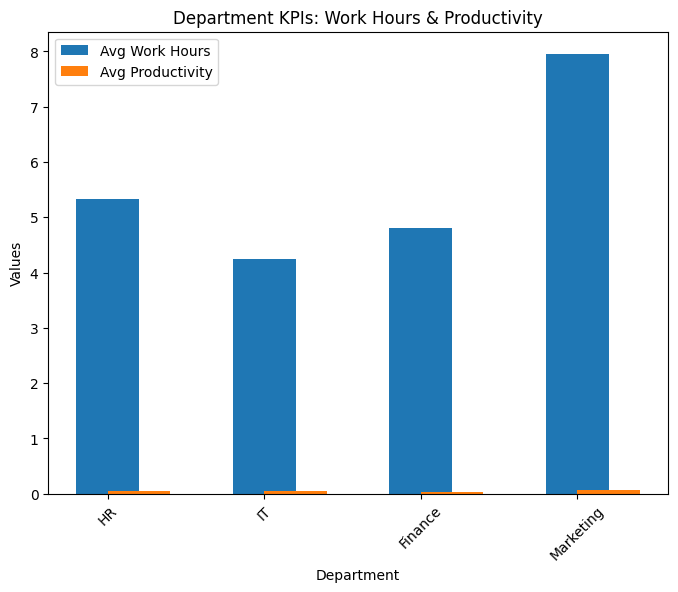

In [0]:
import matplotlib.pyplot as plt
df = department_summary.toPandas()
plt.figure(figsize=(8,6))
plt.bar(df['department'], df['avg_work_hours'], width=0.4, label='Avg Work Hours')
plt.bar(df['department'], df['avg_productivity_score'], width=0.4, label='Avg Productivity', align='edge')
plt.xlabel('Department')
plt.ylabel('Values')
plt.title('Department KPIs: Work Hours & Productivity')
plt.xticks(rotation=45)
plt.legend()
plt.show()

